---

# <center> GFootball Stable-Baselines3 </center>

---
<center><img src="https://raw.githubusercontent.com/DLR-RM/stable-baselines3/master/docs/_static/img/logo.png" width="308" height="268" alt="Stable-Baselines3"></center>


---


In [1]:
%%bash
# dependencies
apt-get -y update > /dev/null
apt-get -y install libsdl2-gfx-dev libsdl2-ttf-dev > /dev/null

# cloudpickle, pytorch, gym
pip3 install "cloudpickle==1.3.0"
pip3 install "torch==1.5.1"
pip3 install "gym==0.17.2"

# gfootball
GRF_VER=v2.8
GRF_PATH=football/third_party/gfootball_engine/lib
GRF_URL=https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_${GRF_VER}.so
git clone -b ${GRF_VER} https://github.com/google-research/football.git
mkdir -p ${GRF_PATH}
wget -q ${GRF_URL} -O ${GRF_PATH}/prebuilt_gameplayfootball.so
cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install . && cd ..

# kaggle-environments
git clone https://github.com/Kaggle/kaggle-environments.git
cd kaggle-environments && pip3 install . && cd ..

# stable-baselines3
git clone https://github.com/DLR-RM/stable-baselines3.git
cd stable-baselines3 && pip3 install . && cd ..

# housekeeping
# rm -rf football kaggle-environments stable-baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gym: filename=gym-0.17.2-py3-none-any.whl size=1650890 sha256=26b456aa55566006847be8ae0f135ad355161756c146bdf416d924b7caa3c3bb
  Stored in directory: /root/.cache/pip/wheels/18/e1/58/89a2aa24e6c2cc800204fc02010612afdf200926c4d6bfe315
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /con

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.5.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.1 which is incompatible.
fastai 2.6.3 requires torch<1.12,>=1.7.0, but you have torch 1.5.1 which is incompatible.
Cloning into 'football'...
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
Cloning into 'kaggle-environme

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
code_path = '/content/drive/My Drive/Colab'
sys.path.insert(0,code_path)




Mounted at /content/drive


In [3]:
import os
import base64
import pickle
import zlib
import gym
import numpy as np
import pandas as pd
import torch as th
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from torch import nn, tensor
from collections import deque
from gym.spaces import Box, Discrete
from kaggle_environments import make
from kaggle_environments.envs.football.helpers import *
from gfootball.env import create_environment, observation_preprocessing
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3.common import results_plotter
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env

from IPython.display import HTML
from visualizer import visualize

from matplotlib import pyplot as plt
%matplotlib inline

opponentpath="/content/drive/MyDrive/Colab/opponent/"
for filename in os.listdir(opponentpath):
  fullpath = opponentpath+filename
  !cp -r $fullpath /content/football/gfootball/scenarios

!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install . && cd ..

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/football
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for gfootball: filename=gfootball-2.8-cp37-cp37m-linux_x86_64.whl size=38786465 sha256=eb244dd1d53942446003de72392fe801706c0cbf440ece0a3b4a3f580f5b8746
  Stored in directory: /tmp/pip-ephem-wheel-cache-it_gvh17/wheels/bb/c2/92/82a23d0c207f5497a23f4316675eb1629e6be474bd2c3be61a
Successfully built gfootball
  Attempting uninstall: gfootball
    Found existing installation: gfootball 2.8
    Uninstalling gfootball-2.8:
      Successfully uninstalled gfootball

---
# Football Gym



In [24]:
class FootballGym(gym.Env):
    spec = None
    metadata = None
    
    def __init__(self, config=None):
        super(FootballGym, self).__init__()
        env_name = "academy_empty_goal_close"
        rewards = "scoring,checkpoints"
        self.reward_mod = True
        if config is not None:
            env_name = config.get("env_name", env_name)
            rewards = config.get("rewards", rewards)
            self.reward_mod = config.get("reward_mod", self.reward_mod)
        self.env = create_environment(
            env_name=env_name,
            stacked=False,
            representation="raw",
            rewards = rewards,
            write_goal_dumps=False,
            write_full_episode_dumps=False,
            render=False,
            write_video=False,
            dump_frequency=1,
            logdir=".",
            extra_players=None,
            number_of_left_players_agent_controls=1,
            number_of_right_players_agent_controls=0)  
        self.action_space = Discrete(19)
        self.observation_space = Box(low=0, high=255, shape=(72, 96, 16), dtype=np.uint8)
        self.obs_stack = deque([], maxlen=4)
        self.prev_obs = self.observation_space.sample()[0]

    def transform_obs(self, raw_obs):
        obs = raw_obs[0]
        obs = observation_preprocessing.generate_smm([obs])
        print(obs[0].shape)
        test=obs[0]
        test = th.from_numpy(test)
        test=th.transpose(test, 0,2)
        print(len(test))
        if not self.obs_stack:
            self.obs_stack.extend([obs] * 4)
        else:
            self.obs_stack.append(obs)

        obs = np.concatenate(list(self.obs_stack), axis=-1)
        obs = np.squeeze(obs)
        return obs

    def reset(self):
        self.obs_stack.clear()
        obs = self.env.reset()
        self.prev_obs = obs[0]
        obs = self.transform_obs(obs)
        return obs
    
    def step(self, action):
        obs, reward, done, info = self.env.step([action])
        final_reward = reward
        self.prev_obs = obs[0]
        obs = self.transform_obs(obs)
        return obs, float(final_reward), done, info
    
check_env(env=FootballGym(), warn=True)

(72, 96, 4)
4
(72, 96, 4)
4
(72, 96, 4)
4
(72, 96, 4)
4
(72, 96, 4)
4
(72, 96, 4)
4
(72, 96, 4)
4
(72, 96, 4)
4
(72, 96, 4)
4
(72, 96, 4)
4
(72, 96, 4)
4
(72, 96, 4)
4


---
# Football CNN


In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.conv2 = conv3x3(out_channels, out_channels, stride)
        
    def forward(self, x):
        residual = x
        out = self.relu(x)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        return out
    
class FootballCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)
        in_channels = observation_space.shape[0]  # channels x height x width
        self.cnn = nn.Sequential(
            conv3x3(in_channels=in_channels, out_channels=32),
            nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, ceil_mode=False),
            ResidualBlock(in_channels=32, out_channels=32),
            ResidualBlock(in_channels=32, out_channels=32),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.linear = nn.Sequential(
          nn.Linear(in_features=52640, out_features=features_dim, bias=True),
          nn.ReLU(),
        )

    def forward(self, obs):
        return self.linear(self.cnn(obs))

---
# LOAD AGENT (MODIFY HERE)

In [ ]:
model = PPO.load("/content/drive/My Drive/RL/final_training/gfootball_academy/120000/best_model.zip")
model.save("ppo_gfootball")

---
# Get Ready for 2D visualization


In [ ]:
%%writefile submission.py
import base64
import pickle
import zlib
import numpy as np
import torch as th
from torch import nn, tensor
from collections import deque
from gfootball.env import observation_preprocessing

state_dict = _STATE_DICT_

state_dict = pickle.loads(zlib.decompress(base64.b64decode(state_dict)))

def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.conv2 = conv3x3(out_channels, out_channels, stride)
        
    def forward(self, x):
        residual = x
        out = self.relu(x)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        return out
    
class PyTorchCnnPolicy(nn.Module):
    global state_dict
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            conv3x3(in_channels=16, out_channels=32),
            nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, ceil_mode=False),
            ResidualBlock(in_channels=32, out_channels=32),
            ResidualBlock(in_channels=32, out_channels=32),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.linear = nn.Sequential(
          nn.Linear(in_features=52640, out_features=256, bias=True),
          nn.ReLU(),
        )
        self.policy_net = nn.Sequential(
          nn.Linear(in_features=256, out_features=64, bias=True),
          nn.Tanh(),
          nn.Linear(in_features=64, out_features=64, bias=True),
          nn.Tanh(),
        )
        self.action_net = nn.Sequential(
          nn.Linear(in_features=64, out_features=19, bias=True),
          nn.ReLU(),
        )
        self.out_activ = nn.Softmax(dim=1)
        self.load_state_dict(state_dict)

    def forward(self, x):
        x = tensor(x).float() / 255.0  # normalize
        x = x.permute(0, 3, 1, 2).contiguous()  # 1 x channels x height x width
        x = self.cnn(x)
        x = self.linear(x)
        x = self.policy_net(x)
        x = self.action_net(x)
        x = self.out_activ(x)
        return int(x.argmax())
    
obs_stack = deque([], maxlen=4)
def transform_obs(raw_obs):
    global obs_stack
    obs = raw_obs['players_raw'][0]
    obs = observation_preprocessing.generate_smm([obs])
    if not obs_stack:
        obs_stack.extend([obs] * 4)
    else:
        obs_stack.append(obs)
    obs = np.concatenate(list(obs_stack), axis=-1)
    return obs

policy = PyTorchCnnPolicy()
policy = policy.float().to('cpu').eval()
def agent(raw_obs):
    obs = transform_obs(raw_obs)
    action = policy(obs)
    return [action]

Writing submission.py


In [ ]:
model = PPO.load("ppo_gfootball")
_state_dict = model.policy.to('cpu').state_dict()
state_dict = {
    "cnn.0.weight":_state_dict['features_extractor.cnn.0.weight'], 
    "cnn.0.bias":_state_dict['features_extractor.cnn.0.bias'], 
    "cnn.2.conv1.weight":_state_dict['features_extractor.cnn.2.conv1.weight'], 
    "cnn.2.conv1.bias":_state_dict['features_extractor.cnn.2.conv1.bias'],
    "cnn.2.conv2.weight":_state_dict['features_extractor.cnn.2.conv2.weight'], 
    "cnn.2.conv2.bias":_state_dict['features_extractor.cnn.2.conv2.bias'], 
    "cnn.3.conv1.weight":_state_dict['features_extractor.cnn.3.conv1.weight'], 
    "cnn.3.conv1.bias":_state_dict['features_extractor.cnn.3.conv1.bias'], 
    "cnn.3.conv2.weight":_state_dict['features_extractor.cnn.3.conv2.weight'], 
    "cnn.3.conv2.bias":_state_dict['features_extractor.cnn.3.conv2.bias'], 
    "linear.0.weight":_state_dict['features_extractor.linear.0.weight'], 
    "linear.0.bias":_state_dict['features_extractor.linear.0.bias'], 
    "policy_net.0.weight":_state_dict['mlp_extractor.policy_net.0.weight'],
    "policy_net.0.bias":_state_dict['mlp_extractor.policy_net.0.bias'],
    "policy_net.2.weight":_state_dict['mlp_extractor.policy_net.2.weight'],
    "policy_net.2.bias":_state_dict['mlp_extractor.policy_net.2.bias'],
    "action_net.0.weight":_state_dict['action_net.weight'],
    "action_net.0.bias":_state_dict['action_net.bias'],
}
state_dict = base64.b64encode(zlib.compress(pickle.dumps(state_dict)))
with open('submission.py', 'r') as file:
    src = file.read()
src = src.replace("_STATE_DICT_", f"{state_dict}")
with open('submission.py', 'w') as file:
    file.write(src)

---
# Evaluation

In [5]:
training_scenarios = {0: "11_vs_11_easy_stochastic",
             1: "11_vs_11_easy_stochastic_2",
             2: "11_vs_11_easy_stochastic_4",
             3: "11_vs_11_stochastic",
             4: "11_vs_11_hard_stochastic_8",
             5: "11_vs_11_hard_stochastic",
             6: "11_vs_11_kaggle",
             7: "lazy_no_early_finish",
             8: "academy_empty_goal_close",
             9: "academy_empty_goal",
             10: "academy_run_to_score",
             11: "academy_run_to_score_with_keeper",
             12: "academy_pass_and_shoot_with_keeper",
             13: "academy_run_pass_and_shoot_with_keeper",
             14: "academy_3_vs_1_with_keeper",
             15: "academy_corner",
             16: "academy_counterattack_easy",
             17: "academy_counterattack_hard",
             18: "academy_single_goal_versus_lazy",
             19: "11_vs_11_kaggle"
}
training_scenario_name = training_scenarios[0]

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
config={"env_name":training_scenario_name, "rewards":"scoring", "reward_mod": False}
test_env = FootballGym(config)
score, timestep = evaluate_policy(model, test_env, n_eval_episodes=10, return_episode_rewards=True)
win=lose=draw=0
for elem in score:
  if elem >0:
    win+=1
  if elem ==0:
    draw+=1
  if elem <0:
    lose+=1

print(score)
print("Average Score Difference", np.mean(score))
print("Std Score Difference", np.std(score))
print("%d win(s) %d draw(s) %d lose(s)"%(win,draw,lose))


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


[-1.0, -1.0, 0.0, -1.0, -1.0, -1.0, 0.0, -1.0, 2.0, -3.0]
Average Score Difference -0.7
Std Score Difference 1.1874342087037917
1 win(s) 2 draw(s) 7 lose(s)


[[{'action': [], 'reward': 0, 'info': {}, 'observation': {'remainingOverageTime': 60, 'step': 0, 'controlled_players': 1, 'players_raw': [{'score': [0, 0], 'right_team_active': [True, True, True, True, True, True, True, True, True, True, True], 'left_team_active': [True, True, True, True, True, True, True, True, True, True, True], 'right_team_yellow_card': [False, False, False, False, False, False, False, False, False, False, False], 'right_team': [[1.0110293626785278, 0.0], [-0.0, -0.02032535709440708], [-0.0, 0.02032535709440708], [0.4266543984413147, 0.19894461333751678], [0.5055146813392639, 0.06459399312734604], [0.5055146813392639, -0.06459297984838486], [0.4266543984413147, -0.19894461333751678], [0.18624374270439148, 0.10739918798208237], [0.270525187253952, 0.0], [0.18624374270439148, -0.10739918798208237], [0.010110294446349144, 0.21961550414562225]], 'left_team_yellow_card': [False, False, False, False, False, False, False, False, False, False, False], 'right_team_roles': [0

KeyError: ignored

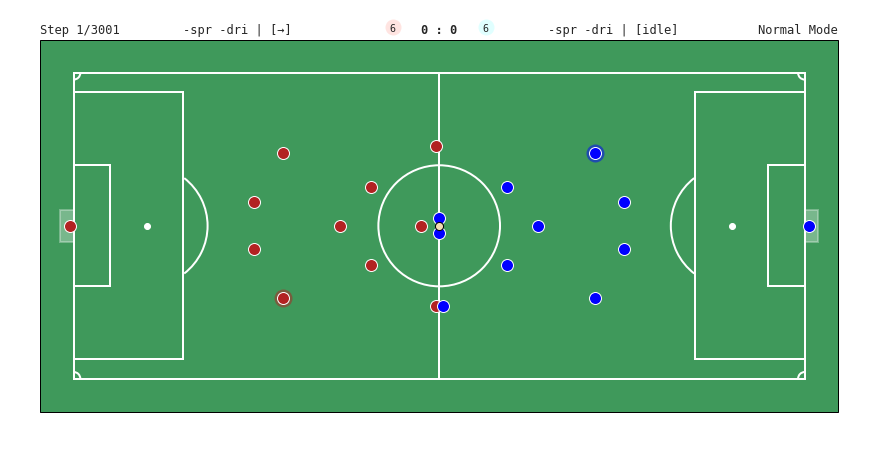

In [ ]:
kaggle_env = make("football", debug = False,
                  configuration={"scenario_name": training_scenario_name, 
                                 "running_in_notebook": True,
                                 "save_video": True})
output = kaggle_env.run(["submission.py", "builtin_ai"])
print(output)
scores = output[-1][0]["observation"]["players_raw"][0]["score"]
print("Scores  {0} : {1}".format(*scores))
print("Rewards {0} : {1}".format(output[-1][0]["reward"], output[-1][1]["reward"]))

viz = visualize(output)

HTML(viz.to_html5_video())




> Modified [Human Readable Visualization](https://www.kaggle.com/jaronmichal/human-readable-visualization)

In [ ]:
env = make("football", configuration={"save_video": True, "scenario_name": training_scenario_name, "running_in_notebook": True}, debug=True)
agent = "submission.py"
output = env.run([agent, "builtin_ai"])[-1]
print('Left player: action = %s, reward = %s, status = %s, info = %s' % (output[0]["action"], output[0]['reward'], output[0]['status'], output[0]['info']))
print('Right player: action = %s, reward = %s, status = %s, info = %s' % (output[1]["action"], output[1]['reward'], output[1]['status'], output[1]['info']))
env.render(mode="human", width=800, height=600)

Staring a new environment 26893789-a29a-47b7-b9b2-173f11fcead1: with scenario: 11_vs_11_easy_stochastic
Resetting environment 26893789-a29a-47b7-b9b2-173f11fcead1: with scenario: 11_vs_11_easy_stochastic
Received video link.
Left player: action = [5], reward = 100, status = DONE, info = {'debug_info': 'Opponent forfeited. You win.'}
Right player: action = [19], reward = None, status = INVALID, info = {'debug_info': 'Invalid action provided: [19].'}


3D VIDEO

In [29]:
import cv2
class FootballGym_Video(gym.Env):
    spec = None
    metadata = None
    
    def __init__(self,scenario_name=None, path=None):
        super(FootballGym_Video, self).__init__()
        env_name = scenario_name
        rewards = "scoring"
        self.env = create_environment(
            env_name=env_name,
            stacked=False,
            representation="raw",
            rewards = rewards,
            write_goal_dumps=False,
            write_full_episode_dumps=True,
            render=True,
            write_video=True,
            dump_frequency=1,
            logdir=path,
            extra_players=None,
            number_of_left_players_agent_controls=1,
            number_of_right_players_agent_controls=0)  
        self.action_space = Discrete(19)
        self.observation_space = Box(low=0, high=255, shape=(72, 96, 16), dtype=np.uint8)
        self.obs_stack = deque([], maxlen=4)
        self.prev_obs = self.observation_space.sample()[0]
        self.print =True
    def transform_obs(self, raw_obs):
        obs = raw_obs[0]
        obs = observation_preprocessing.generate_smm([obs])
        print(obs[0].shape)
        test=obs[0]
        test = th.from_numpy(test)
        test=th.transpose(test, 0,2)
        test=test.cpu().detach().numpy()
        if self.print:
          with np.printoptions(threshold=np.inf):
            print(test[0])
        if not self.obs_stack:
            self.obs_stack.extend([obs] * 4)
        else:
            self.obs_stack.append(obs)
        obs = np.concatenate(list(self.obs_stack), axis=-1)
        obs = np.squeeze(obs)

        return obs

    def reset(self):
    
        self.obs_stack.clear()
        obs = self.env.reset()
        self.prev_obs = obs[0]
        obs = self.transform_obs(obs)
        return obs
    
    def step(self, action):
        obs, reward, done, info = self.env.step([action])
        final_reward = reward
        self.prev_obs = obs[0]
        obs = self.transform_obs(obs)
        self.print=False

        return obs, float(final_reward), done, info
    


In [ ]:
!pip install -U kora
from kora.drive import upload_public

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 4.5 MB/s 


In [30]:
video_dump_path = "/content/drive/MyDrive/submission/"
test_env.env.close()
test_env = FootballGym_Video(training_scenario_name,video_dump_path)
obs = test_env.reset()
done = False
total_reward=0
while not done:
    action, state = model.predict(obs, deterministic=True)
    obs, reward, done, info = test_env.step(action)
    total_reward+=reward
test_env.env.close()

print("Your Score : ", total_reward)
print("video was saved in"+video_dump_path)


# for filename in os.listdir(video_dump_path):
#   if 'avi' in filename:
#     fullpath = video_dump_path+filename

# !ffmpeg -i {fullpath} ./output.mp4

# url = upload_public('output.mp4')
# HTML(f"""<video src={url} width=500 controls/>""")


(72, 96, 4)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0  

NameError: ignored